# 1. 개발환경 구성

## 1-1) 라이브러리 가져오기

In [1]:
# os, 환경변수 관련
import os
from dotenv import load_dotenv

#시각화 관련
from matplotlib import rc
from matplotlib import font_manager
from matplotlib.ticker import FuncFormatter

import matplotlib.pyplot as plt

import pandas as pd
import seaborn as sns
import warnings

# pyspark session 생성
from pyspark.sql import SparkSession
from pyspark.sql.functions import isnan, col, when, sum, round, mean, lit, concat

# pyspark 학습 준비
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler

# pyspark 학습
from pyspark.ml.regression import LinearRegression

# pyspark 모델 평가
from pyspark.ml.evaluation import RegressionEvaluator

## 1-2) 환경 설정

### 1-2-1) MySQL 연결

In [2]:
load_dotenv()

host_ip = os.getenv('host_ip')
DATABASE = os.getenv('DATABASE')
user_id = os.getenv('user_id')
user_password = os.getenv('user_password')

# 환경변수 설정
os.environ['PYSPARK_SUBMIT_ARGS'] = '--jars /usr/local/lib/mysql-connector-java-5.1.49-bin.jar pyspark-shell'

### 1-2-2) 시각화 관련

In [3]:
font_path = '/usr/share/fonts/nanum/NanumMyeongjoBold.ttf'

# 폰트 설정
font_prop = font_manager.FontProperties(fname=font_path)
rc('font', family=font_prop.get_name())

# 경고 무시
warnings.filterwarnings('ignore')

# 음수 깨짐 방지
plt.rcParams['axes.unicode_minus'] = False

## 1-3) spark session 생성

In [4]:
ss = SparkSession\
            .builder\
            .appName('MySQL')\
            .config('spark.executor.memory', '6g')\
            .config('spark.driver.memory', '6g')\
            .getOrCreate()
ss

24/12/20 14:16:46 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


## 1-4) MySQL 연결 및 데이터 가져오기

In [10]:
mysql_url = f'jdbc:mysql://{host_ip}:3306/{DATABASE}?useSSL=false&allowPublicKeyRetrieval=true'

In [11]:
df_tbAPTPrice = ss.read.format('jdbc')\
            .options(
                url = mysql_url
                , driver = 'com.mysql.jdbc.Driver'
                , dbtable = 'tbAPTPrice'
                , user = user_id
                , password = user_password
                    )\
        .load()

df_tbAPTPrice.show(10)

+--------+----------+--------+----------+--------+--------+----------+----+----+-------------------+-------------+-----------+-----------+---+--------+------+--------+----------+--------+--------------------+-----------+---+
|접수연도|자치구코드|자치구명|법정동코드|법정동명|지번구분|지번구분명|본번|부번|             건물명|물건금액_만원|건물면적_m2|토지면적_m2| 층|권리구분|취소일|건축년도|  건물용도|신고구분|신고_공인중개사_지역|계약일_DATE|idx|
+--------+----------+--------+----------+--------+--------+----------+----+----+-------------------+-------------+-----------+-----------+---+--------+------+--------+----------+--------+--------------------+-----------+---+
|    2017|     11710|  송파구|     10500|  석촌동|       1|      대지|0282|0000|           은하빌라|        42000|      73.12|         36|  3|        |      |    2004|연립다세대|        |                    | 2017-08-08|  1|
|    2017|     11560|영등포구|     13200|  신길동|        |          |    |    |                   |        60000|     127.44|         86|   |        |      |    1992|단독다가구|        |                    | 2017

In [12]:
df_tbBaseInterestRate = ss.read.format('jdbc')\
            .options(
                url = mysql_url
                , driver = 'com.mysql.jdbc.Driver'
                , dbtable = 'tbBaseInterestRate'
                , user = user_id
                , password = user_password
                    )\
        .load()

df_tbBaseInterestRate.show(10)

+----------+----------------+
|      date|BaseInterestRate|
+----------+----------------+
|2024-11-28|               3|
|2024-10-11|            3.25|
|2023-01-13|             3.5|
|2022-11-24|            3.25|
|2022-10-12|               3|
|2022-08-25|             2.5|
|2022-07-13|            2.25|
|2022-05-26|            1.75|
|2022-04-14|             1.5|
|2022-01-14|            1.25|
+----------+----------------+
only showing top 10 rows



## 1-5. 데이터 확인

In [13]:
df_tbAPTPrice.printSchema(), df_tbBaseInterestRate.printSchema()

root
 |-- 접수연도: string (nullable = true)
 |-- 자치구코드: string (nullable = true)
 |-- 자치구명: string (nullable = true)
 |-- 법정동코드: string (nullable = true)
 |-- 법정동명: string (nullable = true)
 |-- 지번구분: string (nullable = true)
 |-- 지번구분명: string (nullable = true)
 |-- 본번: string (nullable = true)
 |-- 부번: string (nullable = true)
 |-- 건물명: string (nullable = true)
 |-- 물건금액_만원: string (nullable = true)
 |-- 건물면적_m2: string (nullable = true)
 |-- 토지면적_m2: string (nullable = true)
 |-- 층: string (nullable = true)
 |-- 권리구분: string (nullable = true)
 |-- 취소일: string (nullable = true)
 |-- 건축년도: string (nullable = true)
 |-- 건물용도: string (nullable = true)
 |-- 신고구분: string (nullable = true)
 |-- 신고_공인중개사_지역: string (nullable = true)
 |-- 계약일_DATE: string (nullable = true)
 |-- idx: integer (nullable = true)

root
 |-- date: date (nullable = true)
 |-- BaseInterestRate: string (nullable = true)



(None, None)

In [14]:
df_tbAPTPrice.persist()
df_tbBaseInterestRate.persist()
df_tbAPTPrice.count()

856311

# 2. 전처리

## 2-1) 컬럼 이름 영문화

In [15]:
renamed_columns = ['sumbit_year', 'jachigu_code', 'jachigu_name', 'law_code', 'law_name', 'jibun_gubun', 'jibun_name', 'real_num', 'extra_num', 'building_name', 'building_price', 'building_size', 'land_size', 'floor', 'right_gubun', 'cancel_date', 'building_year', 'building_usage', 'singo_gubun', 'agent_area',  'contract_date', 'idx']

if len(df_tbAPTPrice.columns) == len(renamed_columns):
    renamed_columns_dict = {i : j for i,j in zip(df_tbAPTPrice.columns, renamed_columns)}

for num, i in enumerate(df_tbAPTPrice.columns):
    if i == list(renamed_columns_dict.keys())[num]:
        df_tbAPTPrice = df_tbAPTPrice.withColumnRenamed(i, list(renamed_columns_dict.values())[num])

df_tbAPTPrice.columns

['sumbit_year',
 'jachigu_code',
 'jachigu_name',
 'law_code',
 'law_name',
 'jibun_gubun',
 'jibun_name',
 'real_num',
 'extra_num',
 'building_name',
 'building_price',
 'building_size',
 'land_size',
 'floor',
 'right_gubun',
 'cancel_date',
 'building_year',
 'building_usage',
 'singo_gubun',
 'agent_area',
 'contract_date',
 'idx']

## 2-2) 불필요한 컬럼 삭제

In [16]:
df_tbAPTPrice = \
df_tbAPTPrice.drop('real_num'
                   , 'extra_num'
                   , 'land_size'
                   , 'right_gubun'
                   , 'cancel_date'
                   , 'singo_gubun'
                   , 'agent_area'
                   , 'contract_date')

df_tbAPTPrice.printSchema()

root
 |-- sumbit_year: string (nullable = true)
 |-- jachigu_code: string (nullable = true)
 |-- jachigu_name: string (nullable = true)
 |-- law_code: string (nullable = true)
 |-- law_name: string (nullable = true)
 |-- jibun_gubun: string (nullable = true)
 |-- jibun_name: string (nullable = true)
 |-- building_name: string (nullable = true)
 |-- building_price: string (nullable = true)
 |-- building_size: string (nullable = true)
 |-- floor: string (nullable = true)
 |-- building_year: string (nullable = true)
 |-- building_usage: string (nullable = true)
 |-- idx: integer (nullable = true)



## 2-3) 결측치, 이상치 확인

### 2-3-1) 결측치(NULL) 확인

In [17]:
tmp = df_tbAPTPrice.select(
        [sum(
            when(
                col(i).isNull() | isnan(i),1)\
            .otherwise(0)
            )\
            .alias(i + '_nulls') for i in df_tbAPTPrice.columns
        ]
    ).collect()
    
tmp[0].asDict()

{'sumbit_year_nulls': 0,
 'jachigu_code_nulls': 0,
 'jachigu_name_nulls': 0,
 'law_code_nulls': 0,
 'law_name_nulls': 0,
 'jibun_gubun_nulls': 0,
 'jibun_name_nulls': 0,
 'building_name_nulls': 0,
 'building_price_nulls': 0,
 'building_size_nulls': 0,
 'floor_nulls': 0,
 'building_year_nulls': 3711,
 'building_usage_nulls': 0,
 'idx_nulls': 0}

In [18]:
# 자치구, 법정동, 건물용도별 평균 값의 정수 부분을 건물연식으로 넣어주자
# 주택은 한 두 군데만 짓기보단 마을, 단지별로 싹 착공, 재건축하니, 비슷한 지역의 비슷한 매물이 비슷한 연식일 것이라는 가정
tmp_df = df_tbAPTPrice.withColumn('building_year', col('building_year').cast('double'))\
            .groupby('jachigu_code', 'law_code', 'building_usage')\
            .agg(mean('building_year').alias('avg_building_year'))\
            .withColumn('avg_building_year', col('avg_building_year').cast('int'))
            
tmp_df.show(10)

+------------+--------+--------------+-----------------+
|jachigu_code|law_code|building_usage|avg_building_year|
+------------+--------+--------------+-----------------+
|       11560|   11100|    단독다가구|             1982|
|       11230|   10900|        아파트|             1771|
|       11530|   10700|        아파트|             1983|
|       11200|   11500|        아파트|             2002|
|       11440|   11500|      오피스텔|             2003|
|       11560|   12900|    연립다세대|             2014|
|       11200|   12200|    연립다세대|             2013|
|       11545|   10300|      오피스텔|             2016|
|       11680|   11400|    연립다세대|             2000|
|       11170|   12900|    연립다세대|             1976|
+------------+--------+--------------+-----------------+
only showing top 10 rows



In [19]:
df_tbAPTPrice = df_tbAPTPrice.join(tmp_df, on = ['jachigu_code', 'law_code', 'building_usage'], how = 'left')\
                            .withColumn('building_year'
                                          , when(col('building_year').isNull(), col('avg_building_year'))\
                           .otherwise(col('building_year'))
                                        )

df_tbAPTPrice.persist()

DataFrame[jachigu_code: string, law_code: string, building_usage: string, sumbit_year: string, jachigu_name: string, law_name: string, jibun_gubun: string, jibun_name: string, building_name: string, building_price: string, building_size: string, floor: string, building_year: string, idx: int, avg_building_year: int]

In [20]:
df_tbAPTPrice.selectExpr('*')\
                .where('building_year is NULL')\
                .show(10)

+------------+--------+--------------+-----------+------------+--------+-----------+----------+-------------+--------------+-------------+-----+-------------+---+-----------------+
|jachigu_code|law_code|building_usage|sumbit_year|jachigu_name|law_name|jibun_gubun|jibun_name|building_name|building_price|building_size|floor|building_year|idx|avg_building_year|
+------------+--------+--------------+-----------+------------+--------+-----------+----------+-------------+--------------+-------------+-----+-------------+---+-----------------+
+------------+--------+--------------+-----------+------------+--------+-----------+----------+-------------+--------------+-------------+-----+-------------+---+-----------------+



In [21]:
# 임시 뷰 만들어놓기
df_tbAPTPrice.createOrReplaceTempView('tmp_view')

### 2-3-2) 0인 값 확인 및 처리

In [22]:
tmp = df_tbAPTPrice.select(
        [sum(
            when(
                col(i) == 0 ,1)\
            .otherwise(0)
            )\
            .alias(i + '_0') for i in df_tbAPTPrice.columns
        ]
    ).collect()
    
tmp[0].asDict()

{'jachigu_code_0': 0,
 'law_code_0': 0,
 'building_usage_0': 0,
 'sumbit_year_0': 0,
 'jachigu_name_0': 0,
 'law_name_0': 0,
 'jibun_gubun_0': 0,
 'jibun_name_0': 0,
 'building_name_0': 26,
 'building_price_0': 0,
 'building_size_0': 0,
 'floor_0': 3,
 'building_year_0': 16513,
 'idx_0': 0,
 'avg_building_year_0': 38}

#### 2-3-2-가) building_year가 0인 경우 처리

In [23]:
ss.sql('''
        SELECT
            count(building_year)
        FROM tmp_view
        WHERE building_year = 0
''')\
.show()


+--------------------+
|count(building_year)|
+--------------------+
|               16513|
+--------------------+



In [24]:
df_tbAPTPrice = df_tbAPTPrice.join(tmp_df, on = ['jachigu_code', 'law_code', 'building_usage'], how = 'left')\
                            .withColumn('building_year'
                                          , when(col('building_year') ==0, 'avg_building_year')\
                           .otherwise(col('building_year'))
                                        )

df_tbAPTPrice.persist()                   

DataFrame[jachigu_code: string, law_code: string, building_usage: string, sumbit_year: string, jachigu_name: string, law_name: string, jibun_gubun: string, jibun_name: string, building_name: string, building_price: string, building_size: string, floor: string, building_year: string, idx: int, avg_building_year: int, avg_building_year: int]

In [25]:
df_tbAPTPrice.filter(col('building_year') == 0)\
            .select('jachigu_name', 'law_name', 'building_name')\
            .show()

+------------+--------+-------------+
|jachigu_name|law_name|building_name|
+------------+--------+-------------+
+------------+--------+-------------+



In [26]:
df_tbAPTPrice = df_tbAPTPrice.drop('avg_building_year')
df_tbAPTPrice.persist()

DataFrame[jachigu_code: string, law_code: string, building_usage: string, sumbit_year: string, jachigu_name: string, law_name: string, jibun_gubun: string, jibun_name: string, building_name: string, building_price: string, building_size: string, floor: string, building_year: string, idx: int]

#### 2-3-2-나) building_name이 0인 경우 처리

In [27]:
ss.sql('''
        SELECT
        
            jachigu_code
            , law_code
            , building_usage
            , MAX(jachigu_name)
            , MAX(law_name)
            , MAX(building_usage)
            , MAX(building_name)
            
        FROM tmp_view
        WHERE building_name = 0
        GROUP BY jachigu_code, law_code, building_usage
''').show()

+------------+--------+--------------+-----------------+-------------+-------------------+------------------+
|jachigu_code|law_code|building_usage|max(jachigu_name)|max(law_name)|max(building_usage)|max(building_name)|
+------------+--------+--------------+-----------------+-------------+-------------------+------------------+
|       11620|   10100|      오피스텔|           관악구|       봉천동|           오피스텔|                 .|
|       11620|   10200|      오피스텔|           관악구|       신림동|           오피스텔|                 .|
|       11560|   11400|      오피스텔|         영등포구|    당산동4가|           오피스텔|                 .|
+------------+--------+--------------+-----------------+-------------+-------------------+------------------+



In [28]:
df_tbAPTPrice.select('building_name')\
            .where('building_name == 0')\
            .count()

26

In [29]:
df_tbAPTPrice = df_tbAPTPrice.withColumn('building_name'
                                        , when(col('building_name') == 0
                                               , concat(col('jachigu_name'), lit('_'), col('law_name'), lit('_'), col('building_usage'), lit('_'), lit('이름없음')))\
                            .otherwise(col('building_name'))\
                                        )
df_tbAPTPrice.persist()

DataFrame[jachigu_code: string, law_code: string, building_usage: string, sumbit_year: string, jachigu_name: string, law_name: string, jibun_gubun: string, jibun_name: string, building_name: string, building_price: string, building_size: string, floor: string, building_year: string, idx: int]

#### 2-3-2-다) building_year 일부 및 floor가 0인 건물 제거
- 1953년 한국전쟁 정전 이후 건물만 반영(1953년 7월 27일)
- 1634건 삭제
- 해당 작업 수행으로 floor가 0인 건도 모두 지워짐

In [30]:
df_tbAPTPrice = df_tbAPTPrice.selectExpr('*')\
                            .where('building_year >= 1954')

df_tbAPTPrice.persist()

DataFrame[jachigu_code: string, law_code: string, building_usage: string, sumbit_year: string, jachigu_name: string, law_name: string, jibun_gubun: string, jibun_name: string, building_name: string, building_price: string, building_size: string, floor: string, building_year: string, idx: int]

#### 2-3-2-라) 기타 이상한 값 처리

In [31]:
# 서울 자치구는 25개임
tmp = df_tbAPTPrice.select("jachigu_code").distinct().toPandas()
tmp.count()

jachigu_code    25
dtype: int64

## 2-4) floor 범주화 컬럼 추가

In [32]:
df_tbAPTPrice = df_tbAPTPrice.withColumn('floor_range'
                                 , when((col('floor') >= 0) & (col('floor') < 15), '저층')
                                 .when((col('floor') >= 15) & (col('floor') < 30), '중층')
                                 .when(col('floor') >= 30, '고층')
                                 .when(col('floor') < 0, '지하')
                                .otherwise('제공되지않음')
                                )

## 2-5) 데이터 프레임 확인 및 캐싱

In [33]:
tmp = df_tbAPTPrice.select(
        [sum(
            when(
                col(i) == 0 ,1)\
            .otherwise(0)
            )\
            .alias(i + '_0') for i in df_tbAPTPrice.columns
        ]
    ).collect()
    
tmp[0].asDict()

{'jachigu_code_0': 0,
 'law_code_0': 0,
 'building_usage_0': 0,
 'sumbit_year_0': 0,
 'jachigu_name_0': 0,
 'law_name_0': 0,
 'jibun_gubun_0': 0,
 'jibun_name_0': 0,
 'building_name_0': 0,
 'building_price_0': 0,
 'building_size_0': 0,
 'floor_0': 0,
 'building_year_0': 0,
 'idx_0': 0,
 'floor_range_0': 0}

In [34]:
df_tbAPTPrice.persist()

#임시 뷰 만들어놓기
df_tbAPTPrice.createOrReplaceTempView('tmp_view')

# 3. 시각화

## 3-1) 데이터 프레임 확인

In [35]:
pd_df = df_tbAPTPrice.toPandas()

pd_df.sort_values(by = ['sumbit_year', 'idx'], inplace = True)

pd_df.shape, pd_df.dtypes, pd_df.columns

((838164, 15),
 jachigu_code      object
 law_code          object
 building_usage    object
 sumbit_year       object
 jachigu_name      object
 law_name          object
 jibun_gubun       object
 jibun_name        object
 building_name     object
 building_price    object
 building_size     object
 floor             object
 building_year     object
 idx                int32
 floor_range       object
 dtype: object,
 Index(['jachigu_code', 'law_code', 'building_usage', 'sumbit_year',
        'jachigu_name', 'law_name', 'jibun_gubun', 'jibun_name',
        'building_name', 'building_price', 'building_size', 'floor',
        'building_year', 'idx', 'floor_range'],
       dtype='object'))

## 3-2) 시계열 시각화

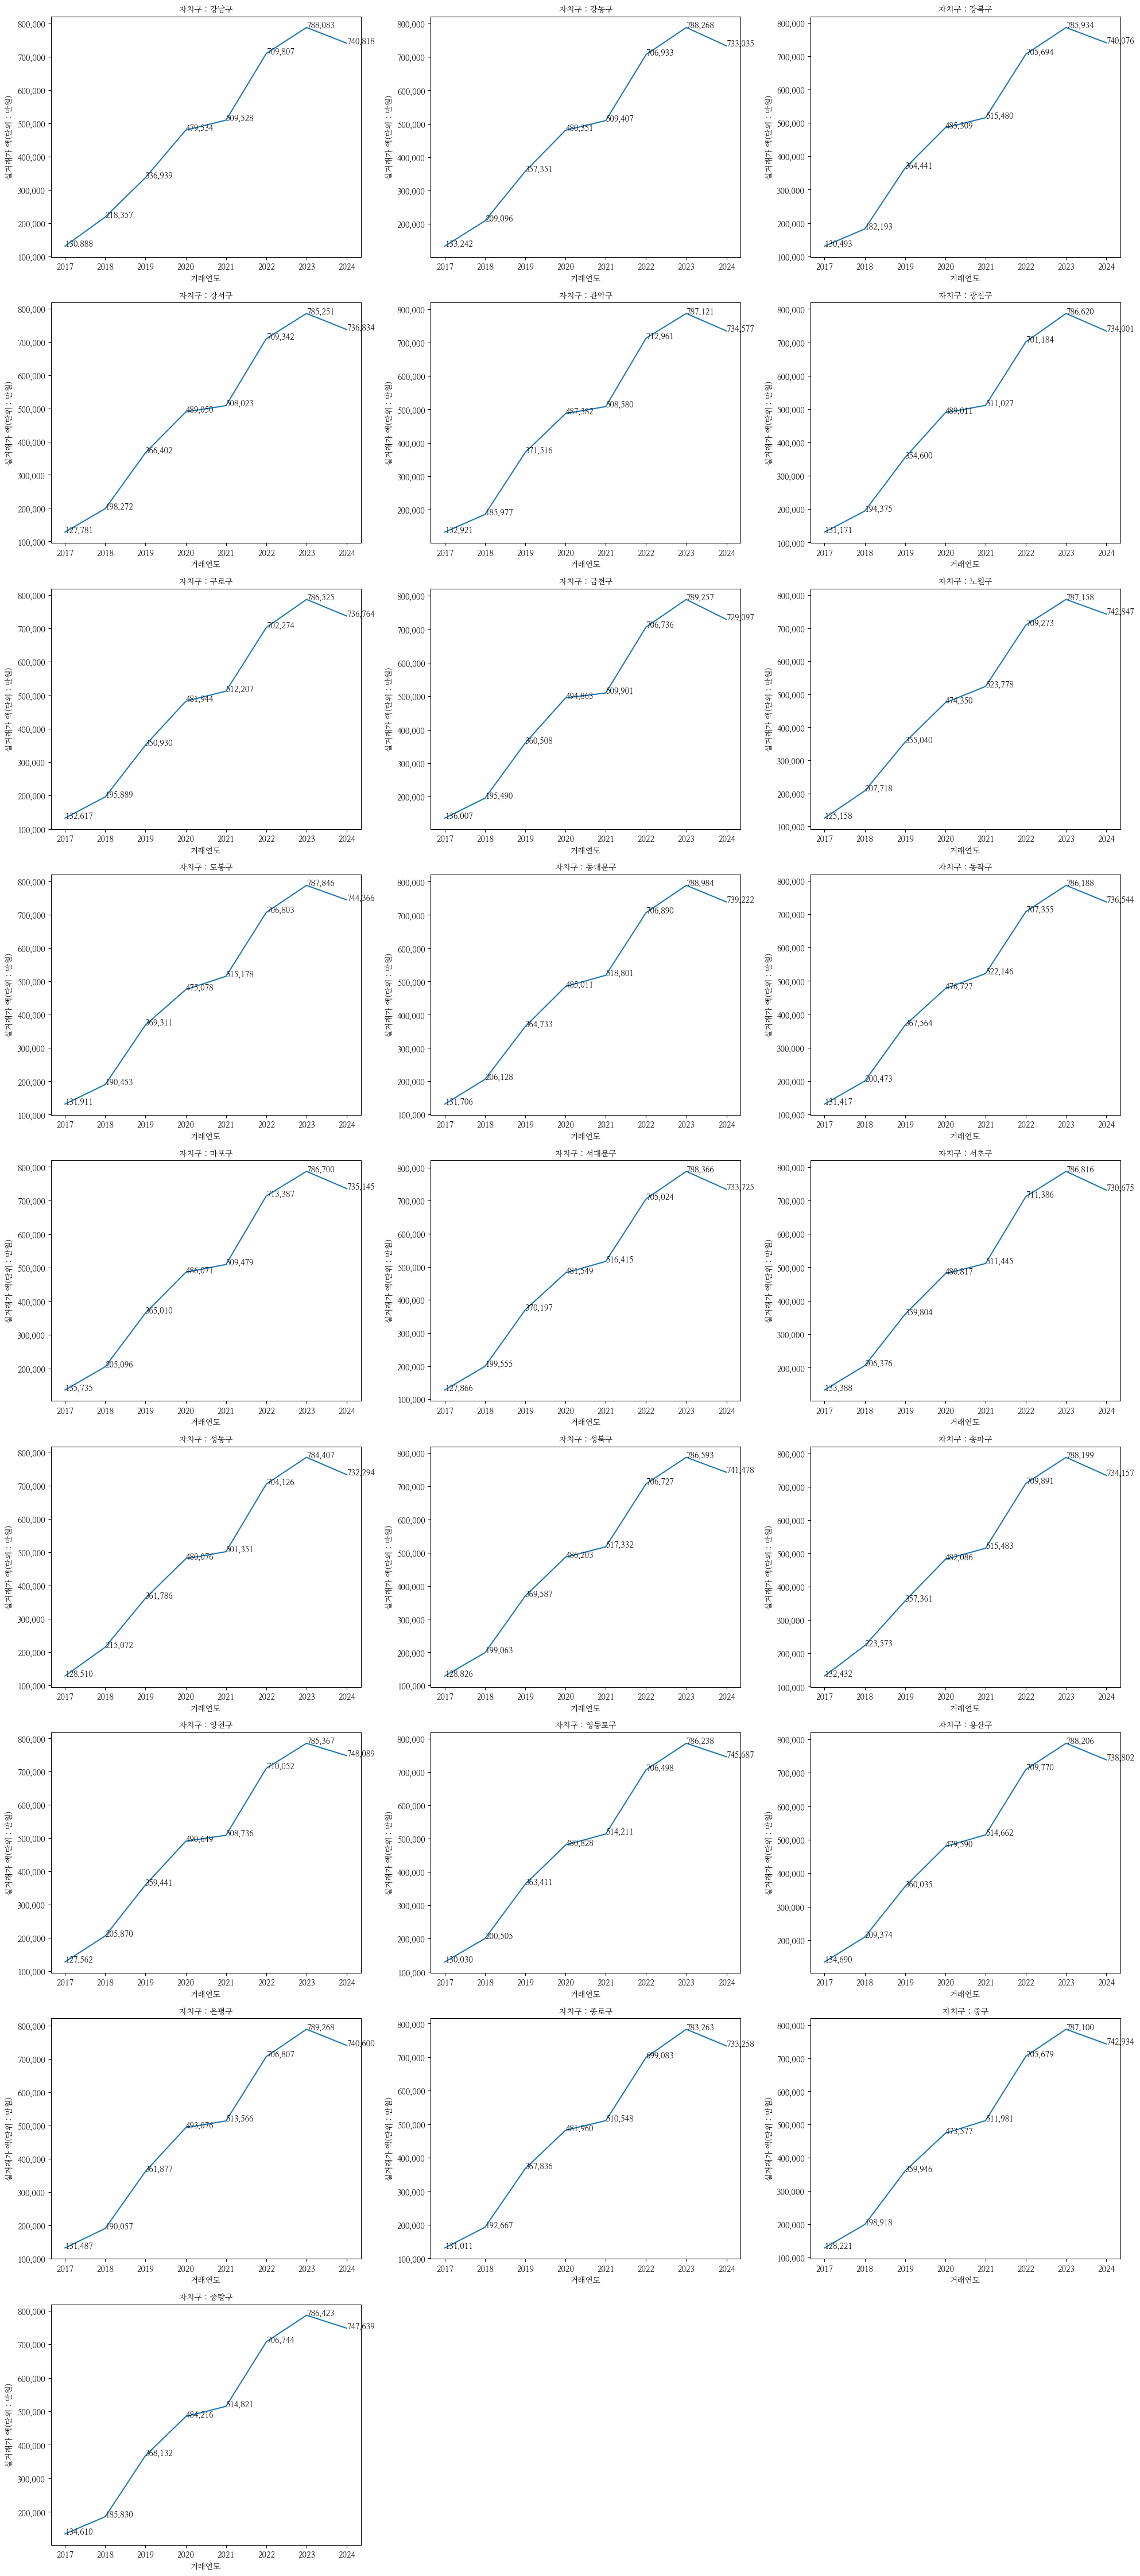

In [36]:
jachigu_list = sorted(list(pd_df['jachigu_name'].drop_duplicates()))

count_jachigu = len(jachigu_list)
r = len(jachigu_list) // 3 + 1
c = 3

fig, axes = plt.subplots(r,c,figsize=(20, r * 5))
axes = axes.flatten() #axes를 1차원으로 변환함으로써 for을 쉽게 돌림

for idx, i in enumerate(jachigu_list):
    ax = axes[idx]
    tmp_df = pd_df[pd_df['jachigu_name'] == i]\
                .groupby(['sumbit_year', 'jachigu_name'])\
                .mean('mean_building_price')\
                .reset_index()\
                .rename(columns = {'idx' : 'mean_building_price'})

    sns.lineplot(
        data = tmp_df
        , x = 'sumbit_year'
        , y = 'mean_building_price'
        , ax = ax
    )
    
    ax.set_title(f'자치구 : {i}', fontsize = 10)
    ax.set_xlabel('거래연도')    
    ax.set_ylabel('실거래가 액(단위 : 만원)')    
    
    # 천단위 구분 기호 추가
    ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{int(x):,}'))

    # 값 표시해주기
    for x, y in zip(tmp_df['sumbit_year'], tmp_df['mean_building_price']):
        ax.text(x,y, f'{y:,.0f}', fontsize = 10, color = 'black', ha = 'left')

# 필요없는 axes는 제거
for i in range(idx + 1, len(axes)):
    axes[i].axis('off')

plt.tight_layout()
plt.show()


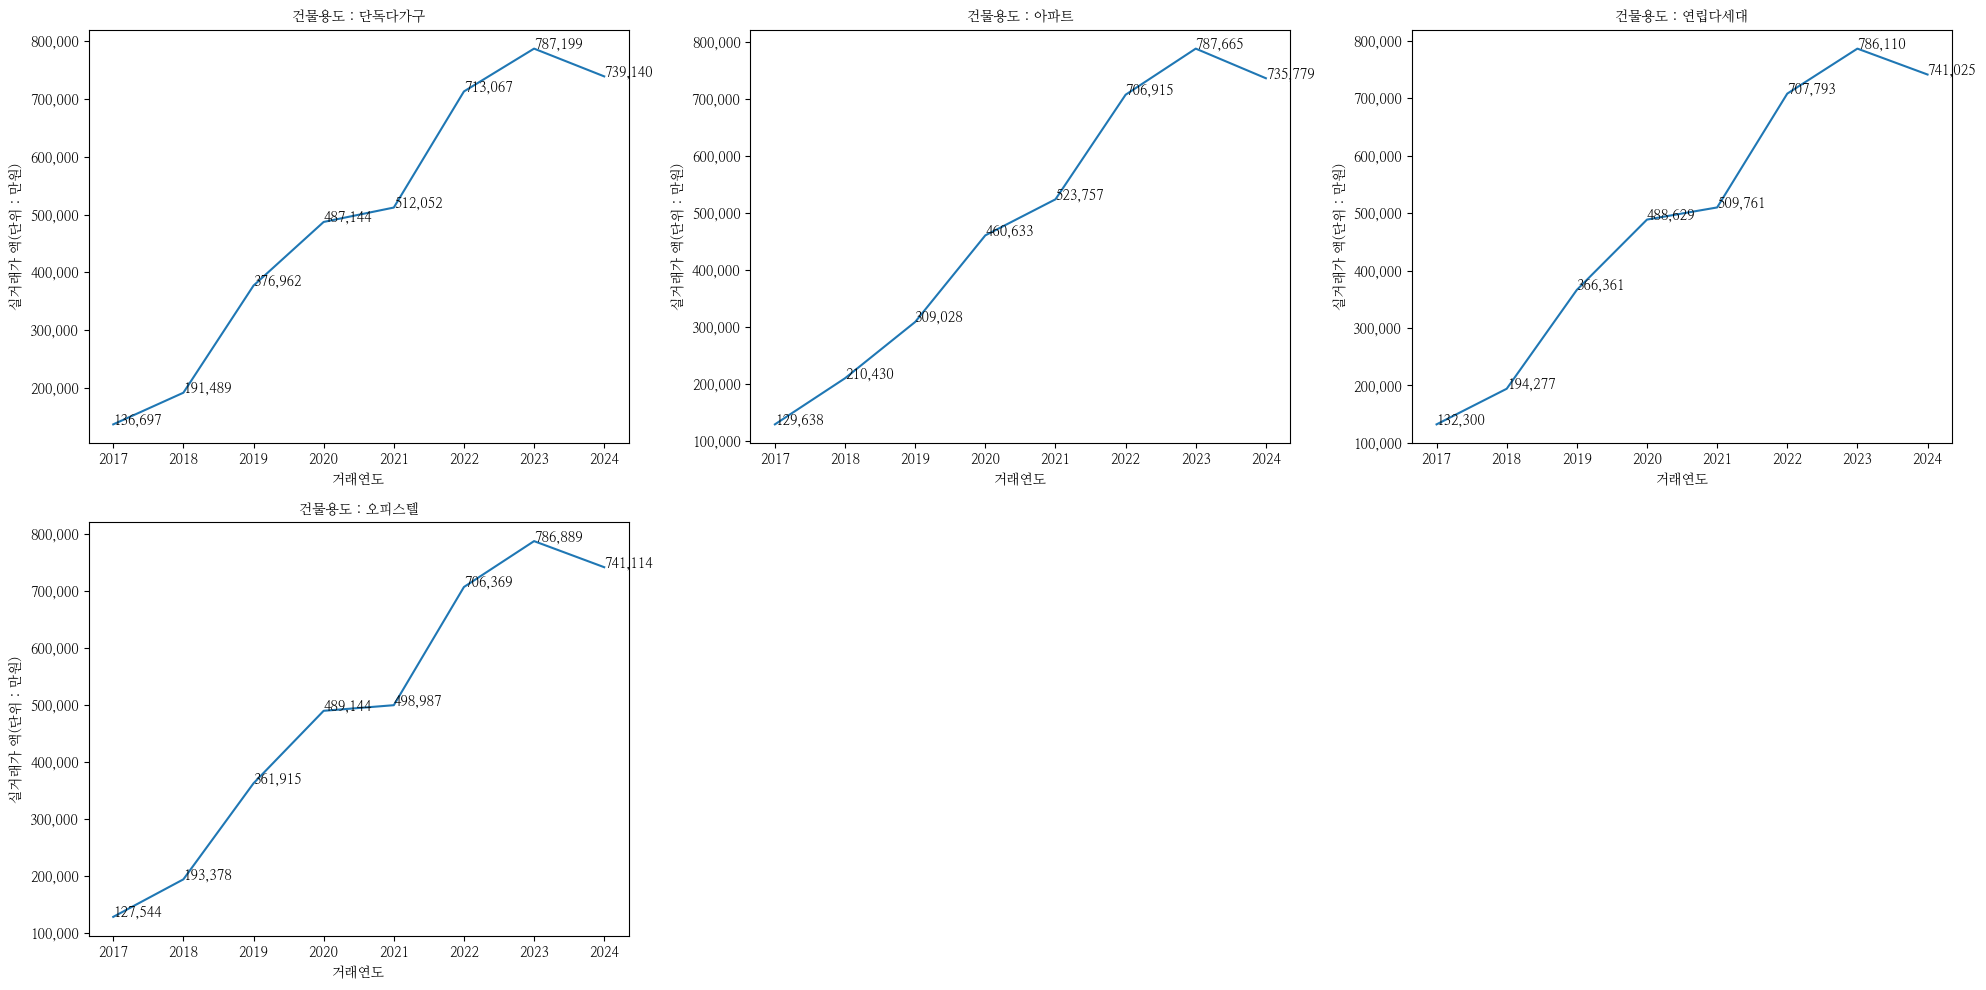

In [37]:
jachigu_list = sorted(list(pd_df['building_usage'].drop_duplicates()))

count_jachigu = len(jachigu_list)
r = len(jachigu_list) // 3 + 1
c = 3

fig, axes = plt.subplots(r,c,figsize=(20, r * 5))
axes = axes.flatten() #axes를 1차원으로 변환함으로써 for을 쉽게 돌림

for idx, i in enumerate(jachigu_list):
    ax = axes[idx]
    tmp_df = pd_df[pd_df['building_usage'] == i]\
                .groupby(['sumbit_year', 'building_usage'])\
                .mean('mean_building_price')\
                .reset_index()\
                .rename(columns = {'idx' : 'mean_building_price'})

    sns.lineplot(
        data = tmp_df
        , x = 'sumbit_year'
        , y = 'mean_building_price'
        , ax = ax
    )
    
    ax.set_title(f'건물용도 : {i}', fontsize = 10)
    ax.set_xlabel('거래연도')    
    ax.set_ylabel('실거래가 액(단위 : 만원)')    
    
    # 천단위 구분 기호 추가
    ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{int(x):,}'))

    # 값 표시해주기
    for x, y in zip(tmp_df['sumbit_year'], tmp_df['mean_building_price']):
        ax.text(x,y, f'{y:,.0f}', fontsize = 10, color = 'black', ha = 'left')

# 필요없는 axes는 제거
for i in range(idx + 1, len(axes)):
    axes[i].axis('off')

plt.tight_layout()
plt.show()
    
            

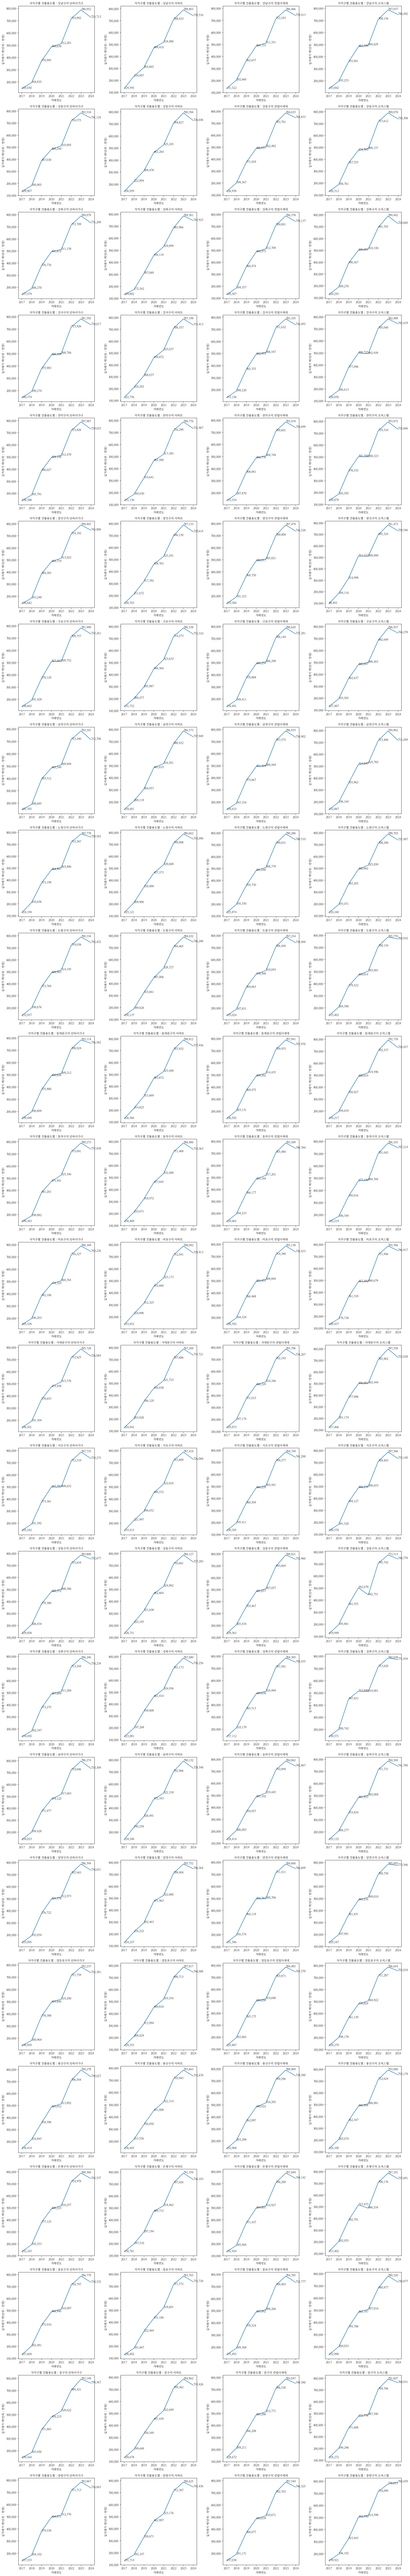

In [38]:
jachigu_usage_list = pd_df[['jachigu_name', 'building_usage']].drop_duplicates().sort_values(by = ['jachigu_name', 'building_usage'])

r = len(jachigu_usage_list) // 4
c = 4

fig, axes = plt.subplots(r,c,figsize=(20, r * 5))
axes = axes.flatten() #axes를 1차원으로 변환함으로써 for을 쉽게 돌림

for idx, (jachi, usage) in enumerate(jachigu_usage_list.values):
    ax = axes[idx]
    tmp_df = pd_df[(pd_df['jachigu_name'] == jachi) & (pd_df['building_usage'] == usage)]\
                .groupby(['jachigu_name', 'building_usage', 'sumbit_year'])\
                .mean('mean_building_price')\
                .reset_index()\
                .rename(columns = {'idx' : 'mean_building_price'})

    sns.lineplot(
        data = tmp_df
        , x = 'sumbit_year'
        , y = 'mean_building_price'
        , ax = ax
    )
    
    ax.set_title(f'자치구별 건물용도별 : {jachi}의 {usage}', fontsize = 10)
    ax.set_xlabel('거래연도')    
    ax.set_ylabel('실거래가 액(단위 : 만원)')    
    
    # 천단위 구분 기호 추가
    ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{int(x):,}'))

    # 값 표시해주기
    for x, y in zip(tmp_df['sumbit_year'], tmp_df['mean_building_price']):
        ax.text(x,y, f'{y:,.0f}', fontsize = 10, color = 'black', ha = 'left')

# 필요없는 axes는 제거
for i in range(idx + 1, len(axes)):
    axes[i].axis('off')

plt.tight_layout()
plt.show()
    
            

# 4. 학습 모델 생성 및 평가

## 4-1) 학습용 데이터 프레임 생성

In [39]:
df_forML = df_tbAPTPrice.drop('jachigu_name'
                   , 'law_name'
                   , 'jibun_gubun'
                   , 'jibun_name'
                   , 'building_name'
                   , 'floor'
                    )

### 4-1-1) Encoding
**1) 문자열 → 숫자형 (cast)**
- `building_price`
- `sumbit_year`
- `building_size`
- `building_year`

---
**2) 범주형 컬럼 처리**  
2-1) **Label Encoding**
- `jachigu_code`
- `law_code`
- `floor → floor_range`

2-2) **One-Hot Encoding**
- `building_usage`

---




In [40]:
tmp_df2 = df_forML

In [41]:
# 범주 개수 확인
tmp_df2.select("jachigu_code").distinct().count(), tmp_df2.select("law_code").distinct().count(), tmp_df2.select("building_usage").distinct().count(), tmp_df2.select("floor_range").distinct().count()

(25, 86, 4, 5)

In [42]:
## 문자열 -> 숫자(cast)
tmp_df3 = tmp_df2.withColumn('building_price', col('building_price').cast('float'))\
                .withColumn('building_size', col('building_size').cast('float'))\
                .withColumn('sumbit_year', col('sumbit_year').cast('int'))\
                .withColumn('building_year', col('building_year').cast('int'))

In [43]:
## 범주형 변수 >> 정수형
indexers_jachigu_code = StringIndexer(inputCol = 'jachigu_code', outputCol = 'INDEX_'+'jachigu_code')
indexers_law_code = StringIndexer(inputCol = 'law_code', outputCol = 'INDEX_'+'law_code')
indexers_floor_range = StringIndexer(inputCol = 'floor_range', outputCol = 'INDEX_'+'floor_range')
indexers_jachigu_code, indexers_law_code, indexers_floor_range

tmp_df4 = indexers_jachigu_code.fit(tmp_df3).transform(tmp_df3)
tmp_df5 = indexers_law_code.fit(tmp_df4).transform(tmp_df4)
tmp_df5 = indexers_floor_range.fit(tmp_df5).transform(tmp_df5)
tmp_df5

DataFrame[jachigu_code: string, law_code: string, building_usage: string, sumbit_year: int, building_price: float, building_size: float, building_year: int, idx: int, floor_range: string, INDEX_jachigu_code: double, INDEX_law_code: double, INDEX_floor_range: double]

In [44]:
indexers_building_usage = StringIndexer(inputCol = 'building_usage', outputCol = 'INDEX_' + 'building_usage')
tmp_df6 = indexers_building_usage.fit(tmp_df5).transform(tmp_df5)
tmp_df6

DataFrame[jachigu_code: string, law_code: string, building_usage: string, sumbit_year: int, building_price: float, building_size: float, building_year: int, idx: int, floor_range: string, INDEX_jachigu_code: double, INDEX_law_code: double, INDEX_floor_range: double, INDEX_building_usage: double]

In [45]:
## one-hot encoding
encoders = OneHotEncoder(inputCol = 'INDEX_'+'building_usage', outputCol = 'ENCODE_' + 'building_usage')
encoders

tmp_df7 = encoders.fit(tmp_df6).transform(tmp_df6)
tmp_df7

DataFrame[jachigu_code: string, law_code: string, building_usage: string, sumbit_year: int, building_price: float, building_size: float, building_year: int, idx: int, floor_range: string, INDEX_jachigu_code: double, INDEX_law_code: double, INDEX_floor_range: double, INDEX_building_usage: double, ENCODE_building_usage: vector]

In [46]:
## one-hot encoding
encoders = OneHotEncoder(inputCol = 'INDEX_'+'floor_range', outputCol = 'ENCODE_' + 'floor_range')
encoders

tmp_df8 = encoders.fit(tmp_df7).transform(tmp_df7)
tmp_df8

DataFrame[jachigu_code: string, law_code: string, building_usage: string, sumbit_year: int, building_price: float, building_size: float, building_year: int, idx: int, floor_range: string, INDEX_jachigu_code: double, INDEX_law_code: double, INDEX_floor_range: double, INDEX_building_usage: double, ENCODE_building_usage: vector, ENCODE_floor_range: vector]

### 4-1-2) Feature 선택

In [47]:
features_cols = ['INDEX_jachigu_code'
                , 'INDEX_law_code'
                , 'ENCODE_building_usage'
                , 'ENCODE_floor_range'
                , 'sumbit_year'
                , 'building_size'
                , 'building_year'
               ]

### 4-1-3) assembler를 통한 feature Vectorized

In [48]:
assembler = VectorAssembler(inputCols = features_cols
                            , outputCol = 'feature'
                           )
tmp_df9 = assembler.transform(tmp_df8)
tmp_df9.select('building_price', 'feature').show(truncate = False)

+--------------+------------------------------------------------------------------------+
|building_price|feature                                                                 |
+--------------+------------------------------------------------------------------------+
|22500.0       |[24.0,25.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,2021.0,18.56999969482422,2021.0] |
|24675.0       |[24.0,25.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,2022.0,18.56999969482422,2021.0] |
|61000.0       |[22.0,31.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,2018.0,26.979999542236328,1981.0]|
|60000.0       |[22.0,31.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,2018.0,47.06999969482422,1971.0] |
|96000.0       |[22.0,31.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,2018.0,66.94999694824219,1971.0] |
|50900.0       |[22.0,31.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,2017.0,40.5,1984.0]              |
|65000.0       |[22.0,31.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,2018.0,77.36000061035156,1984.0] |
|50000.0       |[22.0,31.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,2018.0,47.06999969482422,1971.0] |
|52000.0  

### 4-1-4) 데이터 셋 분할

In [49]:
train_ratio = 0.8
test_ratio = 0.2

In [50]:
train_df, test_df = tmp_df9\
                    .randomSplit([train_ratio, test_ratio], seed = 42)

train_df, test_df


(DataFrame[jachigu_code: string, law_code: string, building_usage: string, sumbit_year: int, building_price: float, building_size: float, building_year: int, idx: int, floor_range: string, INDEX_jachigu_code: double, INDEX_law_code: double, INDEX_floor_range: double, INDEX_building_usage: double, ENCODE_building_usage: vector, ENCODE_floor_range: vector, feature: vector],
 DataFrame[jachigu_code: string, law_code: string, building_usage: string, sumbit_year: int, building_price: float, building_size: float, building_year: int, idx: int, floor_range: string, INDEX_jachigu_code: double, INDEX_law_code: double, INDEX_floor_range: double, INDEX_building_usage: double, ENCODE_building_usage: vector, ENCODE_floor_range: vector, feature: vector])

In [51]:
train_df.count()

671187

In [52]:
train_df = train_df.withColumnRenamed('building_price', 'label')

In [53]:
train_df = train_df.select("label", "feature")

## 4-2) 학습 모델

### 4-2-1) 선형 모델 생성

In [54]:
lr = LinearRegression(featuresCol = 'feature'
                       , labelCol = 'label')

lr

LinearRegression_0147a69c307a

In [55]:
lr_model \
= lr.fit(train_df)

lr_model

24/12/20 14:25:23 WARN Instrumentation: [71dbfe7e] regParam is zero, which might cause numerical instability and overfitting.
24/12/20 14:25:23 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeSystemBLAS
24/12/20 14:25:23 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeRefBLAS
24/12/20 14:25:32 WARN LAPACK: Failed to load implementation from: com.github.fommil.netlib.NativeSystemLAPACK
24/12/20 14:25:32 WARN LAPACK: Failed to load implementation from: com.github.fommil.netlib.NativeRefLAPACK
24/12/20 14:25:32 WARN Instrumentation: [71dbfe7e] Cholesky solver failed due to singular covariance matrix. Retrying with Quasi-Newton solver.


LinearRegressionModel: uid=LinearRegression_0147a69c307a, numFeatures=12

### 4-2-2) 학습 모델 결과

In [56]:
predictions = lr_model.transform(test_df)
predictions.selectExpr(predictions.columns[:-6] + [predictions.columns[-1]]).show(truncate = False)

predictions.select('idx', 'building_price', 'prediction')\
            .withColumn('gap', col('building_price') - col('prediction'))\
            .orderBy(col('gap'))\
            .show(truncate = False)

+------------+--------+--------------+-----------+--------------+-------------+-------------+------+-----------+------------------+--------------+------------------+
|jachigu_code|law_code|building_usage|sumbit_year|building_price|building_size|building_year|idx   |floor_range|INDEX_jachigu_code|INDEX_law_code|prediction        |
+------------+--------+--------------+-----------+--------------+-------------+-------------+------+-----------+------------------+--------------+------------------+
|11170       |12900   |연립다세대    |2017       |28000.0       |38.81        |1991         |79170 |저층       |22.0              |31.0          |18851.958012752235|
|11170       |12900   |연립다세대    |2017       |40000.0       |36.26        |1971         |26472 |저층       |22.0              |31.0          |20388.900337232277|
|11170       |12900   |연립다세대    |2017       |40000.0       |47.68        |1971         |169036|저층       |22.0              |31.0          |27576.525670684874|
|11170       |12900   |연립

+------+--------------+------------------+-------------------+
|idx   |building_price|prediction        |gap                |
+------+--------------+------------------+-------------------+
|219327|970000.0      |2264498.7195249386|-1294498.7195249386|
|695371|580000.0      |1865417.5221770257|-1285417.5221770257|
|520579|710000.0      |1363384.6424558796|-653384.6424558796 |
|593870|480000.0      |1112843.8226714209|-632843.8226714209 |
|504208|590000.0      |1214545.9166222475|-624545.9166222475 |
|37706 |450000.0      |1061322.5631755646|-611322.5631755646 |
|375201|330000.0      |898888.8389956299 |-568888.8389956299 |
|600054|350000.0      |872643.4004846215 |-522643.4004846215 |
|240281|455000.0      |951967.2673356719 |-496967.26733567193|
|379094|171000.0      |653846.4659301583 |-482846.4659301583 |
|340644|225000.0      |702499.570750067  |-477499.570750067  |
|529800|250000.0      |721512.9989617057 |-471512.9989617057 |
|622231|300000.0      |771140.2823335957 |-471140.28233

### 4-2-3) 학습 평가

In [57]:
evaluator = RegressionEvaluator(
    labelCol="building_price",
    predictionCol="prediction",
    metricName="rmse"  # Root Mean Squared Error
)
rmse = evaluator.evaluate(predictions)
print(f"Root Mean Squared Error (RMSE): {rmse}")


Root Mean Squared Error (RMSE): 60006.115010646135


In [58]:
evaluator = RegressionEvaluator(labelCol="building_price", predictionCol="prediction", metricName="r2")
r2 = evaluator.evaluate(predictions)
print(f"R-squared (R²): {r2}")


R-squared (R²): 0.43856402472422373


In [59]:
evaluator = RegressionEvaluator(labelCol="building_price", predictionCol="prediction", metricName="mae")
mae = evaluator.evaluate(predictions)
print(f"Mean Absolute Error (MAE): {mae}")


Mean Absolute Error (MAE): 25568.83690815842


In [60]:
print("Coefficients: " + str(lr_model.coefficients))
print("Intercept: " + str(lr_model.intercept))


Coefficients: [-43.523742000430076,445.5052584758835,-25.61100764230215,33331.822943171006,-1339.857268974856,-91925.16099570882,-97352.47233224136,-80319.70291446864,-102812.53862151167,6248.385990653406,629.3891492968467,-157.09432879645135]
Intercept: -12216696.73893537


### 4-2-4) 학습 결과

굉장히 좋지 못한 성능인 것 같으며, 여러 요인을 feature에 담거나 모델 개선이 필요하다(차원 축소 등 회귀 모델의 성능을 개선할 필요성 많음)

# 5. DB 저장

| **특징**               | **Pyspark (write.format(jdbc))**                       | **Pandas (`to_sql`)**                 |
|-------------------------|-----------------------------------------------|---------------------------------------|
| **처리 속도**           | 대규모 데이터에서 우수한 성능                 | 소규모 데이터에서 적합                |
| **병렬 처리**           | 병렬 처리 가능 (`numPartitions` 설정)         | 단일 프로세스에서 실행               |
| **메모리 사용량**       | 분산 메모리 사용                              | 로컬 메모리만 사용                   |
| **설정 난이도**         | 설정이 복잡할 수 있음                         | 간단하고 직관적인 사용 가능           |
| **실시간성**            | 배치 작업에 적합                              | 실시간 삽입에 더 적합                |
| **적용 대상 데이터 크기**| 대규모 데이터 (GB~TB 이상)                   | 소규모 데이터 (MB~GB)                 |
| **실행 환경**           | 클러스터 환경                                 | 로컬 또는 단일 노드 환경             |

<div style="font-family: 'Segoe UI', Arial, sans-serif; line-height: 1.6; color: #e0e0e0; background-color: #1e1e1e; padding: 20px; border-radius: 10px; border: 1px solid #333;">
    <h3 style="color: #4fc3f7; border-bottom: 2px solid #4fc3f7; padding-bottom: 5px;">numPartitions 예시</h3>
    <pre style="background: #2b2b2b; padding: 15px; border-radius: 8px; border: 1px solid #444; font-size: 14px; overflow-x: auto; color: #d1d1d1;">
df_forML.selectExpr('*')\
    .write.format('jdbc')\
    .options(
        url = mysql_url,
        driver = 'com.mysql.jdbc.Driver',
        dbtable = 'tbMLData',
        user = user_id,
        password = user_password,
        numPartitions = "4"  # 병렬 작업을 위한 파티션 개수 설정
    )\
    .mode('append')\
    .save()
    </pre>
    <h4 style="color: #81d4fa; margin-top: 20px;">데이터 크기 기반:</h4>
    <ul style="list-style-type: circle; margin-left: 20px; color: #b3e5fc;">
        <li><strong>소규모 데이터 (몇 만 행):</strong> <code style="color: #ffab40;">numPartitions = 1</code> (기본값)</li>
        <li><strong>중간 규모 데이터 (수십~수백만 행):</strong> <code style="color: #ffab40;">numPartitions = 4~8</code></li>
        <li><strong>대규모 데이터 (수백만~수억 행):</strong> <code style="color: #ffab40;">numPartitions = 16 이상</code></li>
    </ul>
</div>




## 5-1) 학습 모델 저장

In [ ]:
df_forML.selectExpr('*')\
    .write.format('jdbc')\
    .options(
        url = mysql_url
        , driver = 'com.mysql.jdbc.Driver'
        , dbtable = 'tbMLData'
        , user = user_id
        , password = user_password
            )\
    .mode('append')\
    .save()

## 5-2) 예측값 저장

In [58]:
predictions.select('idx', 'prediction')\
    .write.format('jdbc')\
    .options(
        url = mysql_url
        , driver = 'com.mysql.jdbc.Driver'
        , dbtable = 'lg_prediction'
        , user = user_id
        , password = user_password
            )\
    .mode('append')\
    .save()

## 5-3) DB 저장 결과 통계

### 5-3-1) 학습 모델 저장 통계

In [ ]:
print(f'''{'*'*100}
        2일차''')

db_query = '''SELECT
            	ROUND(AVG(cnt), 2) as `분당 저장한 평균 행 개수`
            FROM
            	(
            	SELECT
            		LEFT(getdate,16) as tt
            		, COUNT(*) as cnt
            		, ROW_NUMBER() OVER (ORDER BY LEFT(getdate,16)) as rr
            	FROM tbMLData
            	WHERE getdate like '2024-12-20%'
            	GROUP BY LEFT(getdate,16)
            ) AS A
            '''

ss.read.format('jdbc')\
            .options(
            url = mysql_url
            , driver = 'com.mysql.jdbc.Driver'
            , query = db_query
            , user = user_id
            , password = user_password            
                )\
            .load()\
            .show()

### 5-3-2) 예측값 저장 통계

대상 데이터
- prediction(모델 예측값)

1회당 저장한 행의 수  
- 166,977행
  
분당 저장한 평균 행 개수 : 아래 쿼리 참고

In [61]:
# 1일차
print(f'''{'*'*100}
        1일차''')
db_query = '''SELECT
                ROUND(AVG(cnt), 2) as `분당 저장한 평균 행 개수`
            FROM
                (
                SELECT
                    LEFT(getdate,16) as tt
                    , COUNT(*) as cnt
                    , ROW_NUMBER() OVER (ORDER BY LEFT(getdate,16)) as rr
                FROM lg_prediction
                WHERE getdate like '2024-12-19%'
                GROUP BY LEFT(getdate,16)
            ) AS A
        '''
tmp = ss.read.format('jdbc')\
            .options(
            url = mysql_url
            , driver = 'com.mysql.jdbc.Driver'
            , query = db_query
            , user = user_id
            , password = user_password            
                )\
            .load()
tmp.show()

# 2일차
print(f'''{'*'*100}
        2일차''')
db_query = '''SELECT
                ROUND(AVG(cnt), 2) as `분당 저장한 평균 행 개수`
            FROM
                (
                SELECT
                    LEFT(getdate,16) as tt
                    , COUNT(*) as cnt
                    , ROW_NUMBER() OVER (ORDER BY LEFT(getdate,16)) as rr
                FROM lg_prediction
                WHERE getdate like '2024-12-20%'
                GROUP BY LEFT(getdate,16)
            ) AS A
        '''

tmp = ss.read.format('jdbc')\
            .options(
            url = mysql_url
            , driver = 'com.mysql.jdbc.Driver'
            , query = db_query
            , user = user_id
            , password = user_password            
                )\
            .load()
tmp.show()

****************************************************************************************************
        1일차


+------------------------+
|분당 저장한 평균 행 개수|
+------------------------+
|                 3975.64|
+------------------------+

****************************************************************************************************
        2일차
+------------------------+
|분당 저장한 평균 행 개수|
+------------------------+
|                 4072.61|
+------------------------+



In [89]:
ss.stop()

24/12/20 14:09:07 ERROR Utils: Uncaught exception in thread Executor task launch worker for task 22.0 in stage 188.0 (TID 6123)
java.lang.NullPointerException
	at org.apache.spark.scheduler.Task.$anonfun$run$2(Task.scala:152)
	at org.apache.spark.util.Utils$.tryLogNonFatalError(Utils.scala:1419)
	at org.apache.spark.scheduler.Task.run(Task.scala:150)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:497)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1439)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:500)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	at java.lang.Thread.run(Thread.java:750)
24/12/20 14:09:07 ERROR Executor: Exception in task 22.0 in stage 188.0 (TID 6123): Block rdd_151_22 not found
24/12/20 14:09:33 ERROR Utils: Uncaught exception in thread Executor task launch worker for task 